In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import pandas as pd

import causalpy as cp

# ITS - refactored code

In [ ]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

## Bayesian

In [ ]:
pymc_result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

In [ ]:
pymc_result.summary()

In [ ]:
pymc_result.print_coefficients()

In [ ]:
pymc_result.plot()

## OLS

In [ ]:
ols_result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.skl_models.OLSLinearRegression(),
)

In [ ]:
ols_result.summary()

In [ ]:
ols_result.print_coefficients()

In [ ]:
ols_result.plot()

# SC - refactored code

In [ ]:
df = cp.load_data("sc")
treatment_time = 70

In [ ]:
pymc_result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

In [ ]:
pymc_result.summary()

In [ ]:
pymc_result.print_coefficients()

In [ ]:
pymc_result.plot()

## OLS

In [ ]:
# Note, we do not want an intercept in this model
ols_result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.WeightedProportion(),
)

In [ ]:
ols_result.summary()

In [ ]:
ols_result.print_coefficients()

In [ ]:
ols_result.plot()

# DiD - refactored code

In [ ]:
df = cp.load_data("did")

In [ ]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

In [ ]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=cp.skl_models.OLSLinearRegression(),
)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

## ANOVA - Pre/Post NEGD

In [ ]:
df = cp.load_data("anova1")

In [ ]:
result = cp.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

# Regression discontinuity

In [ ]:
df = cp.load_data("rd")

In [ ]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

In [ ]:
result.discontinuity_at_threshold

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

In [ ]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.skl_models.OLSLinearRegression(),
    treatment_threshold=0.5,
)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

# Regression Kink

In [5]:
seed = 42
rng = np.random.default_rng(seed)


def f(x, beta, kink):
    return (
        beta[0]
        + beta[1] * x
        + beta[2] * x**2
        + beta[3] * (x - kink) * (x >= kink)
        + beta[4] * (x - kink) ** 2 * (x >= kink)
    )


def generate_data(beta, kink, sigma=0.05, N=50):
    if beta is None:
        beta = rng.random(5)
    x = rng.uniform(-1, 1, N)
    y = f(x, beta, kink) + rng.normal(0, sigma, N)
    df = pd.DataFrame({"x": x, "y": y, "treated": x >= kink})
    return df


kink = 0.5
# linear function with gradient change of 2 at kink point
beta = [0, -1, 0, 2, 0]
sigma = 0.05
df = generate_data(beta, kink, sigma=sigma)

In [6]:
result = cp.RegressionKink(
    df,
    formula=f"y ~ 1 + x + I((x-{kink})*treated)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.1,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [8]:
result.summary()


        ================================Regression Kink=================================
        Formula: y ~ 1 + x + I((x-0.5)*treated)
        Running variable: x
        Kink point on running variable: 0.5

        Results:
        Change in slope at kink point = 1.9
        
Model coefficients:
    Intercept               -0.0053, 94% HDI [-0.018, 0.0075]
    x                       -0.99, 94% HDI [-1, -0.96]
    I((x - 0.5) * treated)  1.9, 94% HDI [1.8, 2.1]
    sigma                   0.04, 94% HDI [0.033, 0.048]


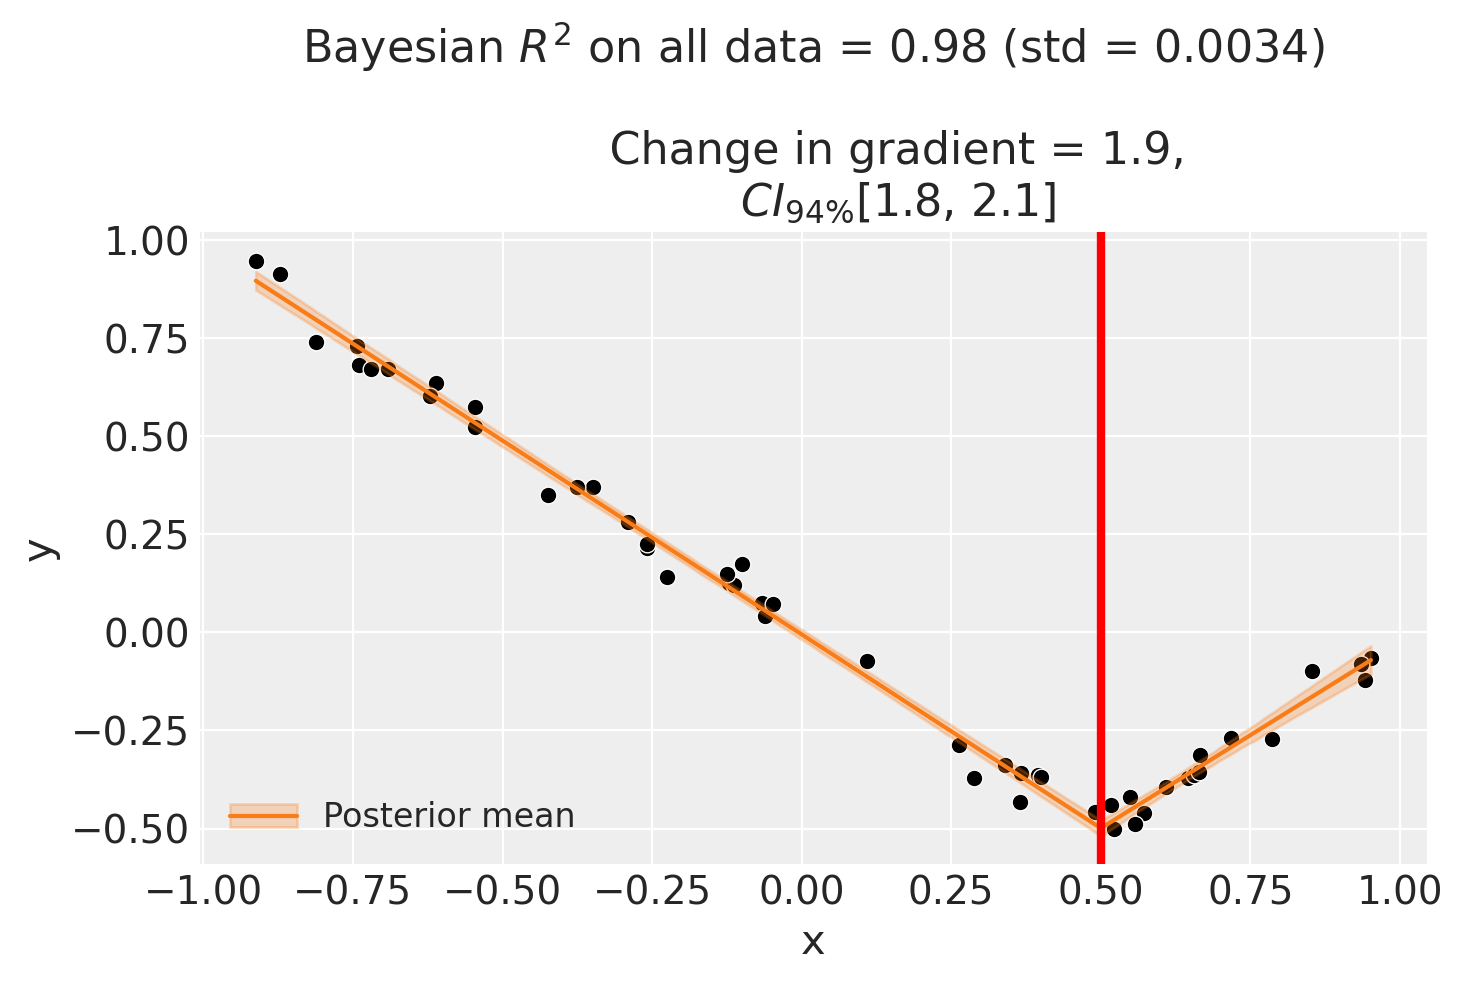

In [9]:
result.plot()